#### 1. Importing Libraries and Loading Data


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

In [3]:
# Load data 
df = pd.read_csv("../data/benin-malanville.csv", parse_dates=['Timestamp'])

### 2. Summary Statistics & Missing-Value Report

In [4]:
# Shape & info
print("Shape:", df.shape)
df.info()

# Summary stats (numeric only)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
summary_stats = df[num_cols].describe().T
summary_stats

Shape: (525600, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  

,count,mean,std,min,25%,50%,75%,max
GHI,525600.0,240.559452,331.131327,-12.9,-2.0,1.8,483.4,1413.0
DNI,525600.0,167.187516,261.710501,-7.8,-0.5,-0.1,314.2,952.3
DHI,525600.0,115.358961,158.691074,-12.6,-2.1,1.6,216.3,759.2
ModA,525600.0,236.589496,326.894859,0.0,0.0,4.5,463.7,1342.3
ModB,525600.0,228.883576,316.536515,0.0,0.0,4.3,447.9,1342.3
Tamb,525600.0,28.179683,5.924297,11.0,24.2,28.0,32.3,43.8
RH,525600.0,54.487969,28.073069,2.1,28.8,55.1,80.1,100.0
WS,525600.0,2.121113,1.603466,0.0,1.0,1.9,3.1,19.5
WSgust,525600.0,2.809195,2.029120,0.0,1.3,2.6,4.1,26.6
WSstdev,525600.0,0.473390,0.273395,0.0,0.4,0.5,0.6,4.2


In [5]:
# Missing values
missing = df.isna().sum()
missing_pct = (missing / len(df)) * 100
missing_report = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
}).sort_values(by='missing_pct', ascending=False)

print("Columns with >5% missing values:")
print(missing_report[missing_report['missing_pct'] > 5])

Columns with >5% missing values:
          missing_count  missing_pct
Comments         525600        100.0


### 3. Outlier Detection & Basic Cleaning

In [6]:
# Drop unused columns
if 'Comments' in df.columns:
    df = df.drop(columns=['Comments'])

# Ensure Timestamp is datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [7]:
# Z-score outlier detection
z_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = np.abs(stats.zscore(df[z_cols]))
outliers_mask = (z_scores > 3).any(axis=1)
n_outliers = outliers_mask.sum()
print(f"Rows with |Z| > 3 in any of {z_cols}: {n_outliers} ({n_outliers/len(df)*100:.2f}%)")

# Optional: Flag or investigate (not dropping by default — could be real events like cloud edges, gusts)
df['outlier_flag'] = outliers_mask

Rows with |Z| > 3 in any of ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']: 7740 (1.47%)


In [8]:
# Export cleaned data 
df_clean = df.copy()
df_clean.to_csv("../data/benin_clean.csv", index=False)
print("✅ Cleaned data saved to `../data/benin_clean.csv`")

✅ Cleaned data saved to `../data/benin_clean.csv`


### 4. Time Series Analysis


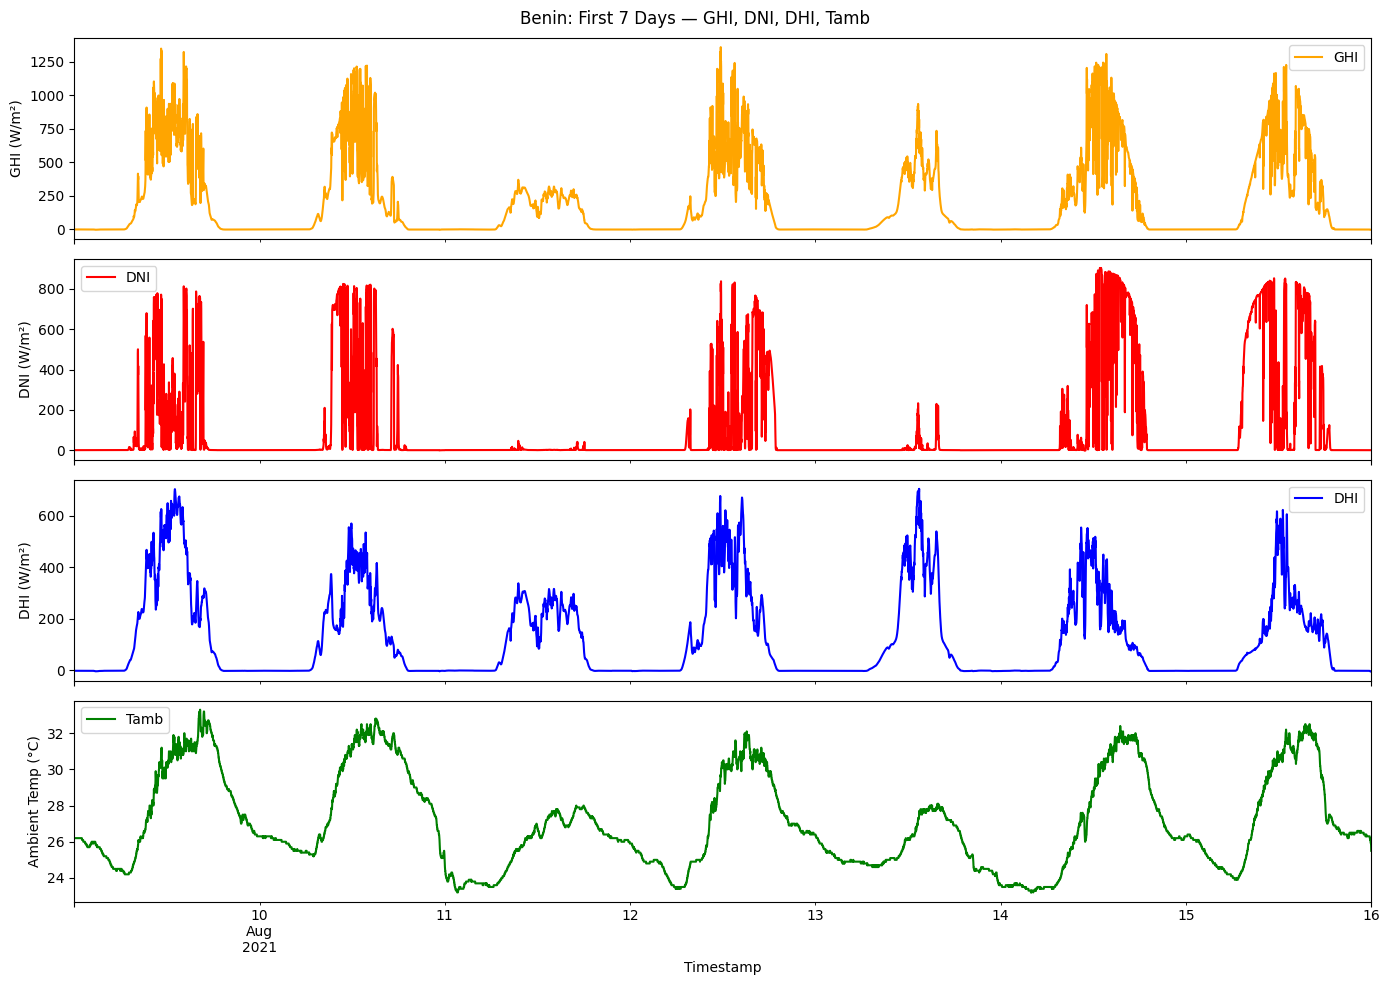

In [13]:
# Plot first 7 days for key variables
start_date = df_clean['Timestamp'].min()
end_date = start_date + pd.Timedelta(days=7)
mask = (df_clean['Timestamp'] >= start_date) & (df_clean['Timestamp'] <= end_date)
subset = df_clean[mask]

fig, ax = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

subset.plot(x='Timestamp', y='GHI', ax=ax[0], label='GHI', color='orange')
ax[0].set_ylabel('GHI (W/m²)'); ax[0].legend()

subset.plot(x='Timestamp', y='DNI', ax=ax[1], label='DNI', color='red')
ax[1].set_ylabel('DNI (W/m²)'); ax[1].legend()

subset.plot(x='Timestamp', y='DHI', ax=ax[2], label='DHI', color='blue')
ax[2].set_ylabel('DHI (W/m²)'); ax[2].legend()

subset.plot(x='Timestamp', y='Tamb', ax=ax[3], label='Tamb', color='green')
ax[3].set_ylabel('Ambient Temp (°C)'); ax[3].legend()

plt.suptitle("Benin: First 7 Days — GHI, DNI, DHI, Tamb")
plt.tight_layout()
plt.show()

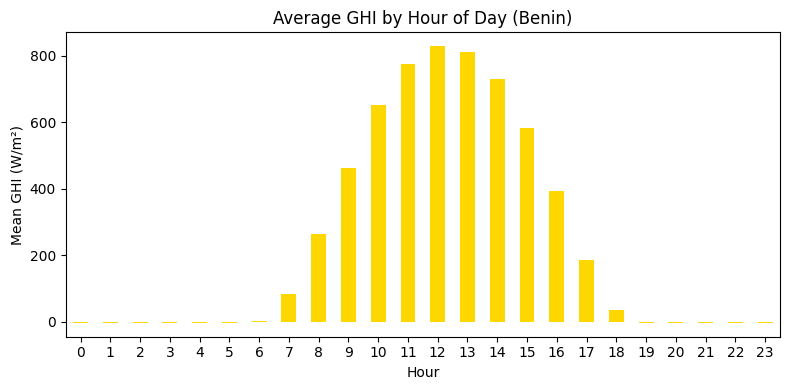

In [14]:
# Diurnal pattern: average GHI by hour of day
df_clean['Hour'] = df_clean['Timestamp'].dt.hour
hourly_ghi = df_clean.groupby('Hour')['GHI'].mean()

plt.figure(figsize=(8,4))
hourly_ghi.plot(kind='bar', color='gold')
plt.title("Average GHI by Hour of Day (Benin)")
plt.xlabel("Hour"); plt.ylabel("Mean GHI (W/m²)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

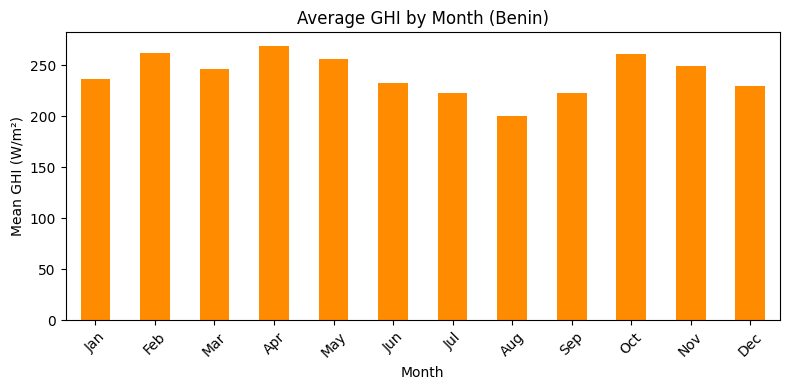

In [15]:
# Monthly trend (if data spans full year)
df_clean['Month'] = df_clean['Timestamp'].dt.month
monthly_ghi = df_clean.groupby('Month')['GHI'].mean()

plt.figure(figsize=(8,4))
monthly_ghi.plot(kind='bar', color='darkorange')
plt.title("Average GHI by Month (Benin)")
plt.xlabel("Month"); plt.ylabel("Mean GHI (W/m²)")
plt.xticks(ticks=range(12), labels=[
    'Jan','Feb','Mar','Apr','May','Jun',
    'Jul','Aug','Sep','Oct','Nov','Dec'],
    rotation=45)
plt.tight_layout()
plt.show()

### 5. Cleaning Impact Analysis

Average ModA and ModB Before vs After Cleaning:


,ModA,ModB
Cleaning,,
Before Cleaning,236.524253,228.816071
After Cleaning,307.229278,301.972165


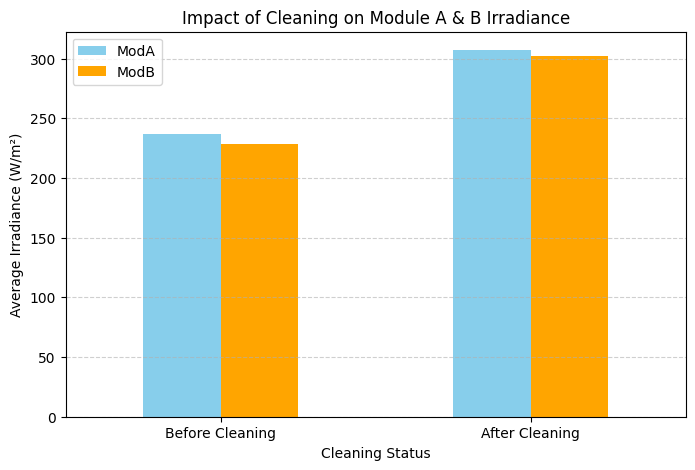

In [9]:
# Ensure 'Cleaning' column exists and is numeric
cleaning_summary = (df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().rename(index={0: 'Before Cleaning', 1: 'After Cleaning'})
)

print("Average ModA and ModB Before vs After Cleaning:")
display(cleaning_summary)

# Plot the effect
cleaning_summary.plot(kind='bar', figsize=(8,5), color=['skyblue', 'orange'])
plt.title("Impact of Cleaning on Module A & B Irradiance")
plt.ylabel("Average Irradiance (W/m²)")
plt.xlabel("Cleaning Status")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()



#### 6. Correlation & Relationship Analysis


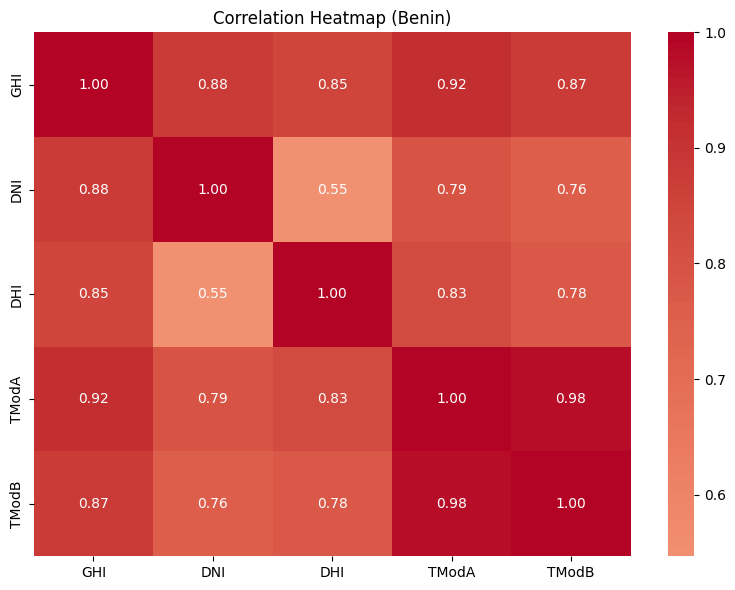

In [19]:
# Correlation heatmap (selected key vars)
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr = df_clean[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Heatmap (Benin)")
plt.tight_layout()
plt.show()

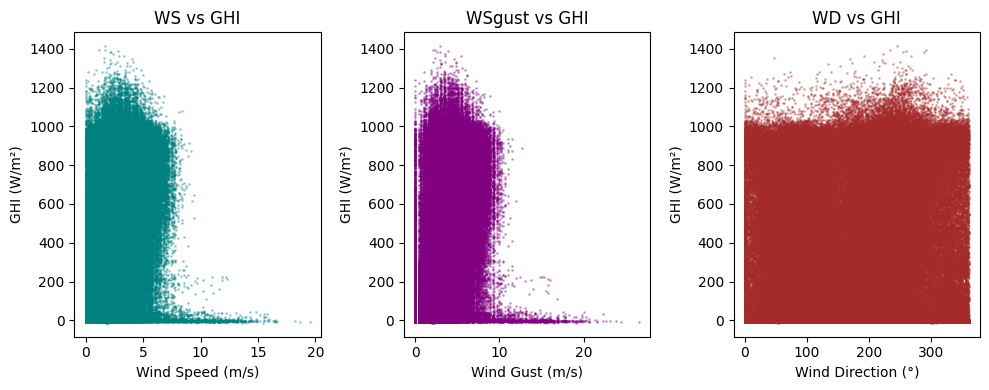

In [18]:
# Scatter: WS vs GHI
plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
plt.scatter(df_clean['WS'], df_clean['GHI'], alpha=0.3, s=1, color='teal')
plt.xlabel("Wind Speed (m/s)"); plt.ylabel("GHI (W/m²)")
plt.title("WS vs GHI")

plt.subplot(1, 3, 2)
plt.scatter(df_clean['WSgust'], df_clean['GHI'], alpha=0.3, s=1, color='purple')
plt.xlabel("Wind Gust (m/s)"); plt.ylabel("GHI (W/m²)")
plt.title("WSgust vs GHI")

plt.subplot(1, 3, 3)
plt.scatter(df_clean['WD'], df_clean['GHI'], alpha=0.3, s=1, color='brown')
plt.xlabel("Wind Direction (°)"); plt.ylabel("GHI (W/m²)")
plt.title("WD vs GHI")

plt.tight_layout()
plt.show()

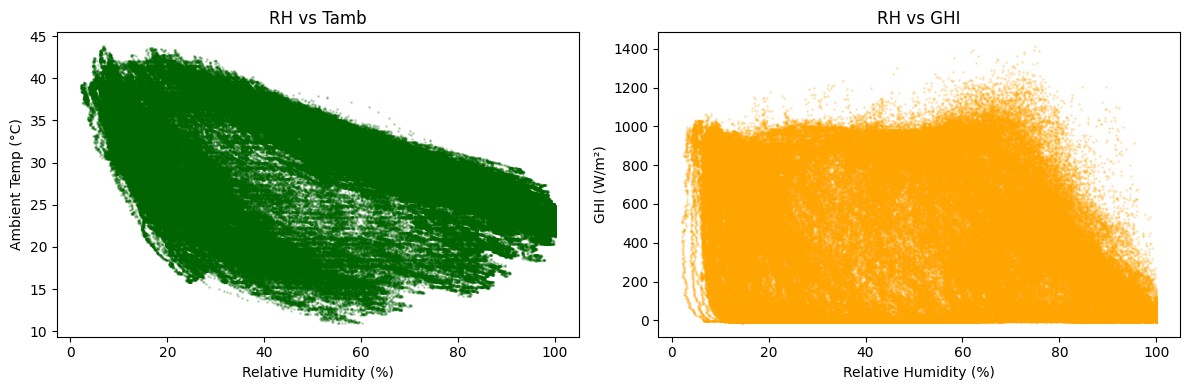

In [20]:
# RH vs Tamb & RH vs GHI
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.2, s=1, color='darkgreen')
ax[0].set_xlabel("Relative Humidity (%)"); ax[0].set_ylabel("Ambient Temp (°C)")
ax[0].set_title("RH vs Tamb")

ax[1].scatter(df_clean['RH'], df_clean['GHI'], alpha=0.2, s=1, color='orange')
ax[1].set_xlabel("Relative Humidity (%)"); ax[1].set_ylabel("GHI (W/m²)")
ax[1].set_title("RH vs GHI")

plt.tight_layout()
plt.show()

#### 7. Wind & Distribution Analysis

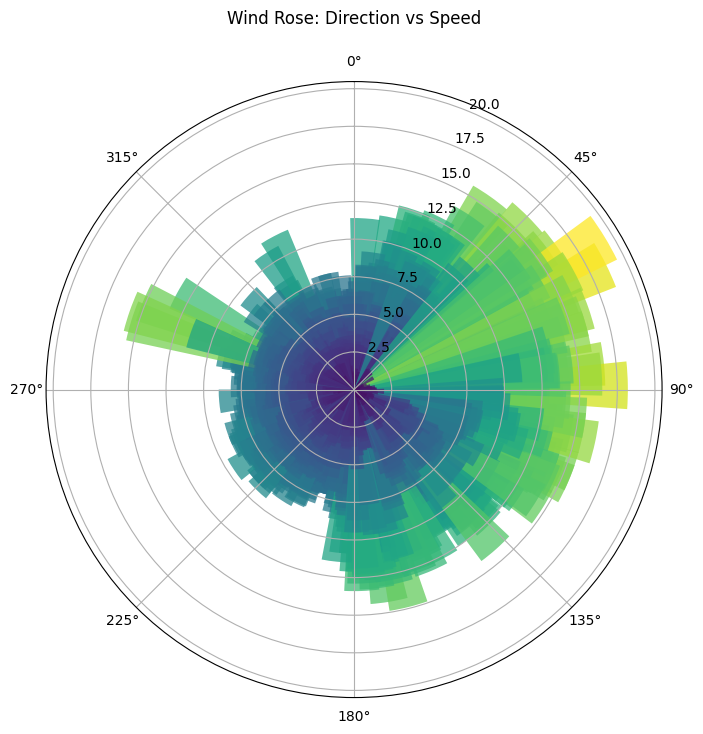

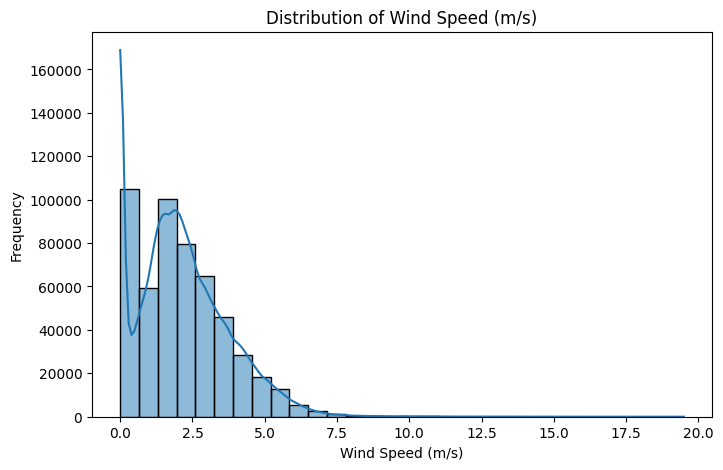

In [ ]:
### Wind Direction and Speed Analysis
import matplotlib.cm as cm

# Drop rows with missing WD or WS
wind_data = df_clean[['WD', 'WS']].dropna()

# Convert wind direction from degrees to radians
wd_rad = np.deg2rad(wind_data['WD'])

# Wind rose-style plot using polar coordinates
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(wd_rad, wind_data['WS'], width=np.deg2rad(10), color=cm.viridis(wind_data['WS']/wind_data['WS'].max()), alpha=0.75)
ax.set_theta_zero_location('N')  # North at top
ax.set_theta_direction(-1)       # Clockwise
plt.title("Wind Rose: Direction vs Speed", y=1.08)
plt.show()



In [ ]:
# from windrose import WindroseAxes
# import matplotlib.pyplot as plt

# ax = WindroseAxes.from_ax()
# ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
# ax.set_title("Wind Rose: Benin")
# plt.show()


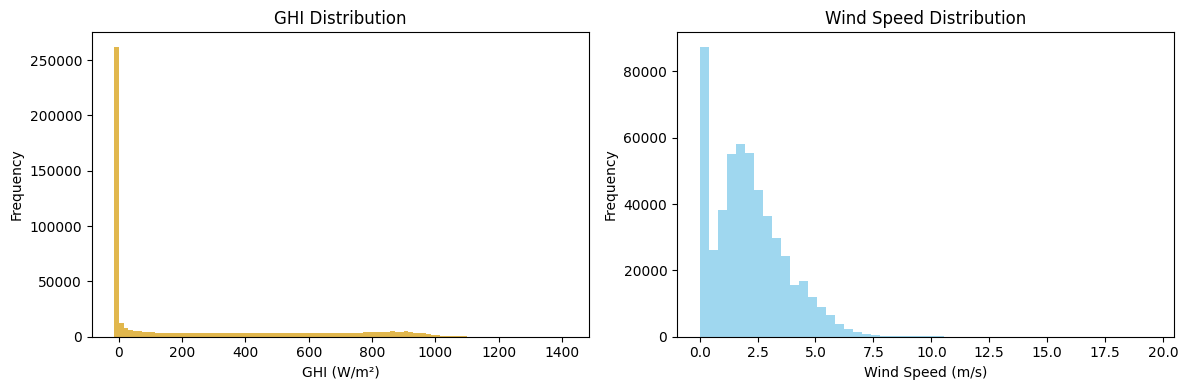

In [22]:
# Histograms: GHI & WS
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].hist(df_clean['GHI'], bins=100, color='goldenrod', alpha=0.8)
ax[0].set_xlabel("GHI (W/m²)"); ax[0].set_ylabel("Frequency")
ax[0].set_title("GHI Distribution")

ax[1].hist(df_clean['WS'], bins=50, color='skyblue', alpha=0.8)
ax[1].set_xlabel("Wind Speed (m/s)"); ax[1].set_ylabel("Frequency")
ax[1].set_title("Wind Speed Distribution")

plt.tight_layout()
plt.show()

#### 8. Temperature & Humidity Analysis


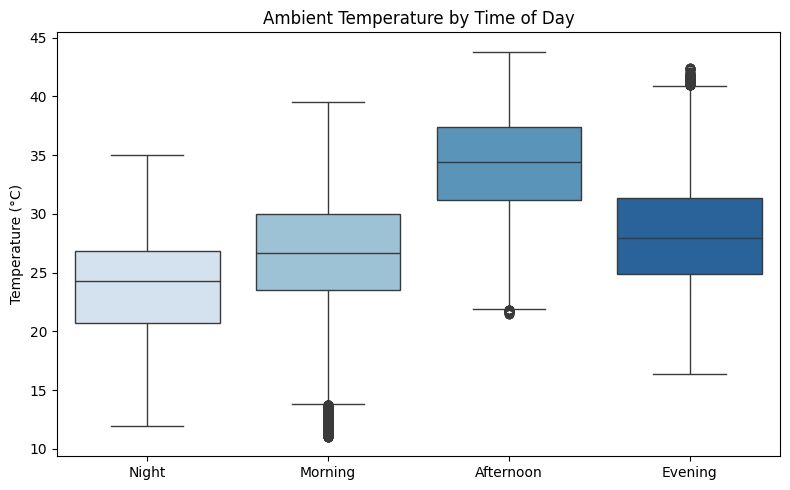

In [23]:
# Tamb vs RH — stratify by time of day
df_clean['TimeOfDay'] = pd.cut(df_clean['Hour'], 
                              bins=[-1, 5, 11, 17, 23], 
                              labels=['Night', 'Morning', 'Afternoon', 'Evening'])

plt.figure(figsize=(8,5))
sns.boxplot(data=df_clean, x='TimeOfDay', y='Tamb', hue='TimeOfDay', palette='Blues')
plt.title("Ambient Temperature by Time of Day")
plt.ylabel("Temperature (°C)")
plt.xlabel("")
plt.legend([],[], frameon=False)  # hide duplicate legend
plt.tight_layout()
plt.show()

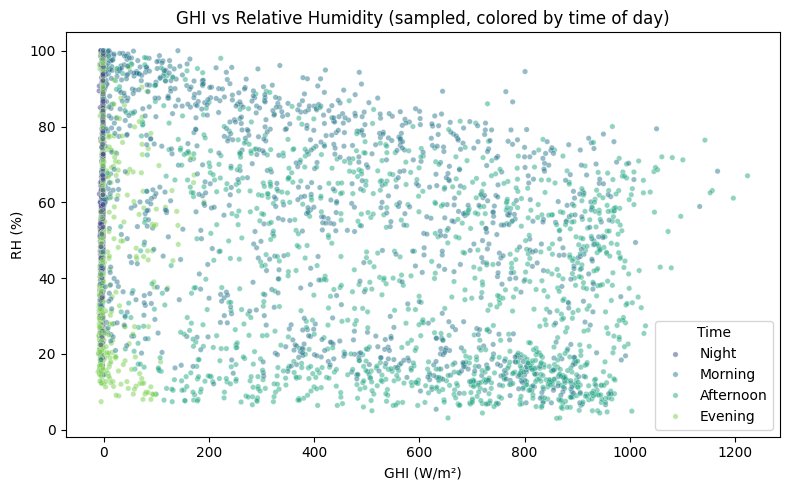

In [24]:
# RH vs GHI — colored by time of day
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_clean.sample(5000), x='GHI', y='RH', hue='TimeOfDay', 
                alpha=0.5, s=15, palette='viridis')
plt.title("GHI vs Relative Humidity (sampled, colored by time of day)")
plt.xlabel("GHI (W/m²)"); plt.ylabel("RH (%)")
plt.legend(title='Time')
plt.tight_layout()
plt.show()


#### 9. Bubble Chart: GHI vs Tamb, size = RH


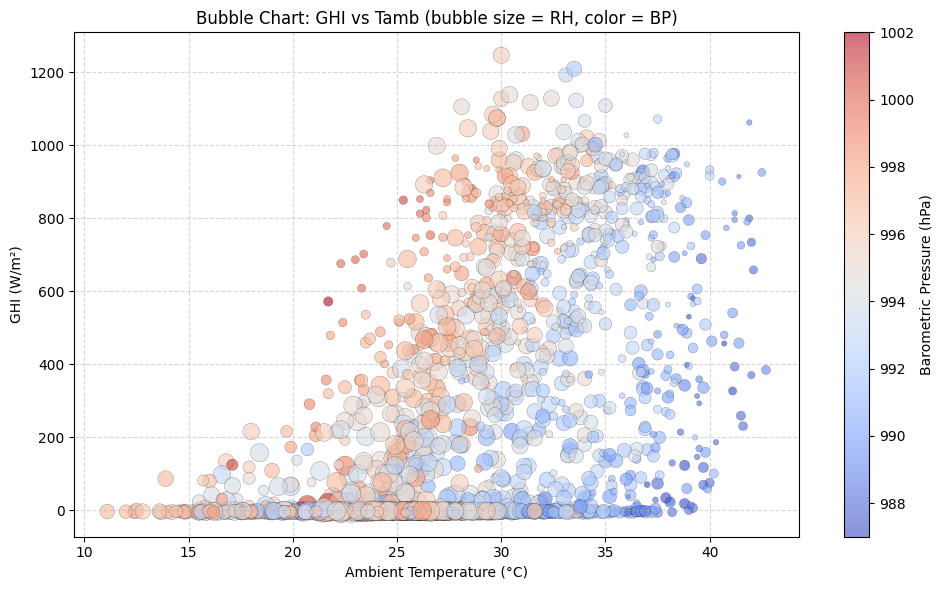

In [25]:
# Sample for clarity
sample = df_clean.sample(n=2000, random_state=42)

plt.figure(figsize=(10,6))
scatter = plt.scatter(
    sample['Tamb'], 
    sample['GHI'], 
    s=sample['RH']*2,  # scale bubble size
    c=sample['BP'], 
    cmap='coolwarm',
    alpha=0.6,
    edgecolors='k',
    linewidth=0.2
)
plt.colorbar(scatter, label='Barometric Pressure (hPa)')
plt.xlabel("Ambient Temperature (°C)")
plt.ylabel("GHI (W/m²)")
plt.title("Bubble Chart: GHI vs Tamb (bubble size = RH, color = BP)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()